In [18]:
!pip install transformers
!pip install gdown # download from google drive

In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

import torch
import pickle
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from transformers import BertModel, BertTokenizerFast

# Language-agnostic BERT Sentence Embedding (LaBSE)

LaBSE is a recent transformer model developed by google to create Language Agnostic Embeddings.

According to their results LaBSE outperforms LASER in most multilingual benchmarks with the advantage of running well in windows 😂.

In this notebook I will give you the basics on "how to get sentence embeddings using LaBSE". I hope that this will foster some ideas for the project.

[Official Google blog](https://ai.googleblog.com/2020/08/language-agnostic-bert-sentence.html)

LaBSE follows a dual encoder architecture in which the source (text to be translated) and target text (translated text) are encoded using a shared transformer embedding network separately. The model is then trained in a translation ranking task in which the text representations of paraphares and translations is forced to be close together.

In [20]:
# Transformer loading and initialization

tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
labse = BertModel.from_pretrained("setu4993/LaBSE")
if torch.cuda.is_available():
    labse = labse.cuda()
    print('cuda available')
labse = labse.eval()

cuda available


# DATASET

In [21]:
%cd /content/
%rm -rf /content/corpus/

!gdown https://drive.google.com/uc?id=1AB2pkEQ0muhhUC7hq2dyjewRCdluX4RK
!unzip corpus.zip
%rm -rf corpus.zip

/content
Downloading...
From: https://drive.google.com/uc?id=1AB2pkEQ0muhhUC7hq2dyjewRCdluX4RK
To: /content/corpus.zip
17.8MB [00:00, 31.5MB/s]
Archive:  corpus.zip
   creating: corpus/.ipynb_checkpoints/
  inflating: corpus/.ipynb_checkpoints/preprocessing-checkpoint.ipynb  
   creating: corpus/cs-en/
  inflating: corpus/cs-en/scores.csv  
   creating: corpus/de-en/
   creating: corpus/de-en/.ipynb_checkpoints/
  inflating: corpus/de-en/.ipynb_checkpoints/BLEUscore-checkpoint.ipynb  
  inflating: corpus/de-en/.ipynb_checkpoints/ROUGE-checkpoint.ipynb  
  inflating: corpus/de-en/BLEUscore.ipynb  
  inflating: corpus/de-en/chrF_img.png  
  inflating: corpus/de-en/laser.ipynb  
  inflating: corpus/de-en/ROUGE.ipynb  
  inflating: corpus/de-en/scores.csv  
   creating: corpus/en-fi/
  inflating: corpus/en-fi/.DS_Store  
  inflating: corpus/en-fi/relative-ranks.csv  
  inflating: corpus/en-fi/scores.csv  
   creating: corpus/en-zh/
  inflating: corpus/en-zh/scores.csv  
   creating: corpus

In [22]:
scores_en_zh = pd.read_csv("corpus/en-zh/scores.csv")
scores_en_zh.head(2)

,source,reference,translation,z-score,avg-score,annotators
0,"""In the GISS model's simulation, Venus' slow s...",GSIS的科学家AnthonyDelGenio在新闻稿中解释说：“在GISS模型的模拟模型中...,戈达德太空研究所科学家安东尼·德尔·杰尼奥在新闻发布会上解释说：“在戈达德太空研究所的模型模...,-1.171867,50.0,1
1,Ai Yanhan of China in the Women's 4 x 200m Fre...,中国在英国女性4x200mFreestreyWTE中的最后被称为：“中国14岁的孩子从球下降...,参加女子4x200米自由泳接力赛决赛的中国小将艾衍含被这样描述：“那名14岁的中国小姑娘犯了...,-2.255403,26.5,2


In [23]:
srt = ["source", "reference", "translation"]
language_pairs = [
    "cs-en",
    "de-en",
    "en-fi",
    "en-zh",
    "ru-en",
    "zh-en",
]
scores = {pair: pd.read_csv(f"corpus/{pair}/scores.csv") for pair in language_pairs}

In [24]:
scores['cs-en']['avg-score'].head(2).tolist()

[60.0, 44.0]

In [26]:
#Calculate LaBSE tokens

tokens = {pair: {t: tokenizer(scores[pair][t].tolist(),
                              return_tensors="pt", # pytorch
                              padding=True # padding to the longest in a batch
                              ) for t in srt} for pair in language_pairs}

In [7]:
#tokens["cs-en"]['source'].keys()

In [27]:
def calcEmbeddings(tokens, N_patittions=200):

    if torch.cuda.is_available():
        input_ids = torch.chunk(tokens['input_ids'].cuda(), N_patittions)
        token_type_ids = torch.chunk(tokens['token_type_ids'].cuda(), N_patittions)
        attention_mask = torch.chunk(tokens['attention_mask'].cuda(), N_patittions)
    else:
        input_ids = torch.chunk(tokens['input_ids'], N_patittions)
        token_type_ids = torch.chunk(tokens['token_type_ids'], N_patittions)
        attention_mask = torch.chunk(tokens['attention_mask'], N_patittions)
    N_patittions = len(input_ids)

    # initialization
    token = {'input_ids' : input_ids[0],
            'token_type_ids': token_type_ids[0],
            'attention_mask' : attention_mask[0]
            }
    
    with torch.no_grad():
        embeddings = labse(**token).pooler_output

    for p in tqdm(range(1, N_patittions)):
        token = {'input_ids' : input_ids[p],
                 'token_type_ids': token_type_ids[p],
                 'attention_mask' : attention_mask[p]
                 }
        with torch.no_grad():
            embeddings = torch.cat([embeddings, labse(**token).pooler_output])
    
    return embeddings

In [ ]:
# calculate embeddings

embeddings = {pair: {t: calcEmbeddings(tokens[pair][t]) for t in srt}
                    for pair in language_pairs}


 35%|███▌      | 70/199 [00:23<00:46,  2.80it/s]


In [ ]:
# %cd /content/
with open(r"LaBSE_embeddings.pkl", "wb") as f:
     pickle.dump(embeddings, f)

In [ ]:
# Release RAM

#del labse
#torch.cuda.empty_cache() 
gc.collect()

In [ ]:
# import io
# !gdown https://drive.google.com/uc?id=1I83RSCTqHgw6dp1q7vLdr1ac_WfXOM5b \
# -O LaBSE_embeddings.pkl

# with open(r"LaBSE_embeddings.pkl", "rb") as f:
#     if torch.cuda.is_available():
#         labse_embeddings = torch.load(f)
#     else:
#     # Doesnt work!
#         labse_embeddings = torch.load(f, map_location=torch.device('cpu'))

# Fully Connected Network

In [ ]:
class DenseNetwork(nn.Module):
    def __init__(self, input_size):
        super(DenseNetwork, self).__init__()
        self.input_size = input_size
        self.middle_net = nn.Sequential(
            nn.Linear(input_size * 2, input_size),  # (1536, 768)
            nn.ReLU(),
            nn.Linear(input_size, input_size // 2), #(768, 384)
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(input_size // 2, input_size // 4),  #(384, 192),
            nn.Softmax(dim=input_size // 4)
            )
        self.outer_net = nn.Sequential(
            nn.Linear(input_size // 2, input_size // 4),  # (384, 192)
            nn.ReLU(),
            nn.Linear(input_size // 4, input_size // 8), #(192, 96)
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(input_size // 8, input_size // 16),  #(96, 48)
            nn.Relu(),
            nn.Linear(input_size // 16, 1),  #(48, 1)
            )

    def forward(self, source, reference, translation):
        x = torch.cat([source, reference], dim=1)
        x = self.middle_net(x)
        y = torch.cat([source, translation], dim=1)
        y = self.middle_net(y)
        z = torch.cat([x, y], dim=1)
        return self.outer_net(z)

# TRAINING MODELS

In [ ]:
%cd /content/
%rm -rf radam.py

!gdown https://drive.google.com/uc?id=1OpPRHftwAe_s6WHEJBkStmF2DAK6bM4v -O radam.py


/content
Downloading...
From: https://drive.google.com/uc?id=1OpPRHftwAe_s6WHEJBkStmF2DAK6bM4v
To: /content/radam.py
100% 11.8k/11.8k [00:00<00:00, 14.9MB/s]


In [ ]:
from radam import RAdam, PlainRAdam, AdamW

In [ ]:
def load_data(pair):
    """
    returns
       tensors: source, reference, translation, labels
    """
    # tensors (N, 768)
    source = labse_embeddings[pair]['source']
    reference = labse_embeddings[pair]['reference']
    translation = labse_embeddings[pair]['translation']

    labels =  torch.tensor(scores[pair]['avg-score'])

    if torch.cuda.is_available():
        source = source.cuda()
        reference = reference.cuda()
        translation = translation.cuda()
        labels = labels.cuda()
        
    return source, reference, translation, labels

In [ ]:
def train_model(pair,
                epochs=200, batch_size=64, lr=0.01,
                num_workers=0, log_interval=10):
    # Loader parameters
    pin_memory = True
    if torch.cuda.is_available():
        pin_memory = False
    
    params = {'batch_size': batch_size,
                    'shuffle': True,
                    'num_workers': num_workers,
                    'pin_memory' : pin_memory
          }

    # load data
    source, reference, translation, labels = load_data(pair)
    
    # train
    dataset = TensorDataset(source, reference, translation, labels)
    loader = DataLoader(dataset, **params)

    # Initialize model
    model = DenseNetwork(input_size=768)
    model.train()
    if torch.cuda.is_available():
        model = model.cuda()

    # Optimizer and Loss Criterion
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training loop
    summary = {'epoch' : [],
               'train_loss' : [],
               #'val_loss' : []
               }

    for epoch in range(epochs):
        for batch_idx, (src, ref, trs, target) in enumerate(loader):
            model.train()
            optimizer.zero_grad()
            output = model(src, ref, trs)
            loss = criterion(output, target.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

        if epoch % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.2f}'.format(
                    epoch,
                    loss.data,
                    #val_loss.data
                    ))
            summary['epoch'].append(epoch)
            summary['train_loss'].append(loss.data)
            #summary['val_loss'].append(val_loss.data)

    return model, summary

In [ ]:
# def train_model(pair,
#                 epochs=200, batch_size=64, lr=0.01,
#                 num_workers=0, log_interval=10):
#     # Loader parameters
#     pin_memory = True
#     if torch.cuda.is_available():
#         pin_memory = False
    
#     train_params = {'batch_size': batch_size,
#                     'shuffle': True,
#                     'num_workers': num_workers,
#                     'pin_memory' : pin_memory
#           }

#     # load data
#     source, reference, translation, labels = load_data(pair)
    
#     # train-val split
#     dataset = TensorDataset(source, reference, translation, labels)
#     train_size = int(0.9 * len(dataset))
#     val_size = len(dataset) - train_size 
#     train, val = random_split(dataset, [train_size, val_size],
#                               generator=torch.Generator())
#     # train
#     train_loader = DataLoader(train, **train_params)
#     # validation
#     val_params = {'batch_size': val_size,
#                   'shuffle': True,
#                   'num_workers': num_workers,
#                   'pin_memory' : pin_memory
#                  }
#     val_loader = DataLoader(val, **val_params)
#     for i, (src, ref, trs, target) in enumerate(val_loader):
#         val_src, val_ref, val_trs, val_target = src, ref, trs, target

#     # Initialize model
#     model = DenseNetwork(input_size=768)
#     model.train()
#     if torch.cuda.is_available():
#         model = model.cuda()

#     # Optimizer and Loss Criterion
#     optimizer = RAdam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()

#     # Training loop
#     summary = {'epoch' : [],
#                'train_loss' : [],
#                'val_loss' : []
#                }
#     for epoch in range(epochs):
#         for batch_idx, \
#          (tr_src, tr_ref, tr_trs, tr_target) in enumerate(train_loader):
#             model.train()
#             optimizer.zero_grad()
#             output = model(tr_src, tr_ref, tr_trs)
#             loss = criterion(output, tr_target.unsqueeze(1).float())
#             loss.backward()
#             optimizer.step()

#             # Validation
#             model.eval()
#             with torch.no_grad():
#                 val_output = model(val_src, val_ref, val_trs)
#                 val_loss = criterion(val_output, val_target.unsqueeze(1).float())

#         if epoch % log_interval == 0:
#             print('Train Epoch: {} \tLoss: {:.2f} \tValidation Loss: {:.2f}'.format(
#                     epoch,
#                     loss.data,
#                     val_loss.data
#                     ))
#             summary['epoch'].append(epoch)
#             summary['train_loss'].append(loss.data)
#             summary['val_loss'].append(val_loss.data)

#     return model, summary

In [ ]:
model_cs_en, summary = train_model('cs-en', epochs=1000, batch_size=64, lr=0.001)

NameError: ignored

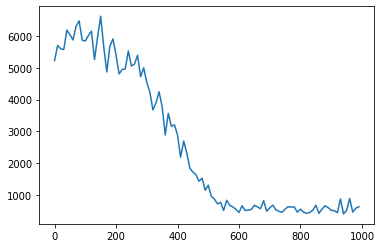

In [ ]:
plt.plot(summary['epoch'], summary['train_loss'])
#plt.plot(summary['epoch'], summary['val_loss'])

plt.show()

# Predict

In [ ]:
model_cs_en.eval()

with torch.no_grad():
    if torch.cuda.is_available():
        output = model(source.cuda(), reference.cuda(), translation.cuda())
    else:
        output = model(source, reference, translation)

output

tensor([[69.4778],
        [69.4778],
        [69.4778],
        ...,
        [69.4778],
        [69.4778],
        [69.4778]], device='cuda:0')

In [ ]:
labels

tensor([60.0000, 44.0000, 96.5000,  ..., 32.0000, 76.0000, 55.0000],
       device='cuda:0', dtype=torch.float64)